In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
real = pd.read_csv("../data/True.csv")
fake = pd.read_csv("../data/Fake.csv")

real["label"] = 1
fake["label"] = 0

df = pd.concat([real, fake], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df[["title", "text", "label"]]
df.dropna(inplace=True)

print(df.head())

                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text  label  
0  Donald Trump s White House is in chaos, and th...      0  
1  Now that Donald Trump is the presumptive GOP n...      0  
2  Mike Pence is a huge homophobe. He supports ex...      0  
3  SAN FRANCISCO (Reuters) - California Attorney ...      1  
4  Twisted reasoning is all that comes from Pelos...      0  


In [3]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

In [4]:
X = df["clean_text"]
y = df["label"]

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

In [5]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/usr/local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:35:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [6]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_vec, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

/usr/local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:37:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/core.py:158: 

Cross-validation accuracy: 0.998 ± 0.000


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


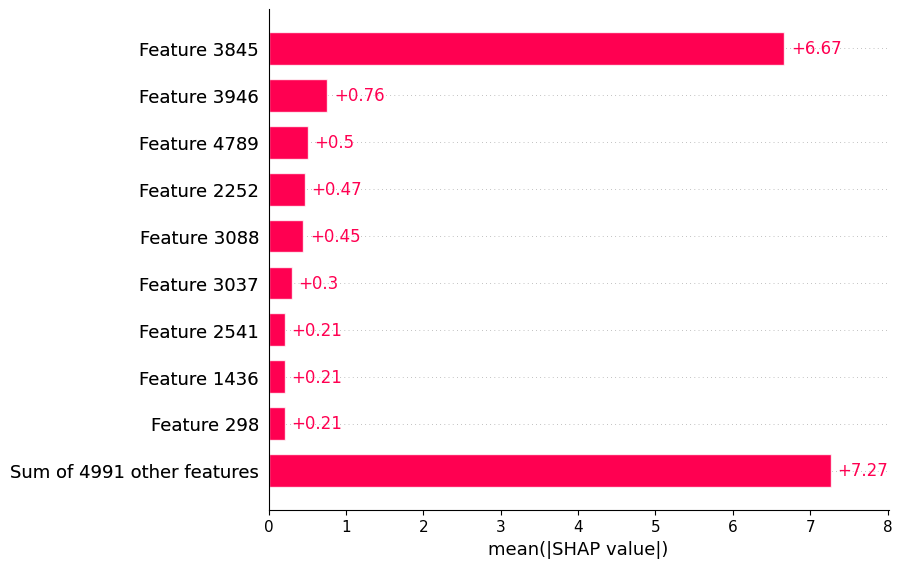

In [7]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_vec[:100])
shap.plots.bar(shap_values)

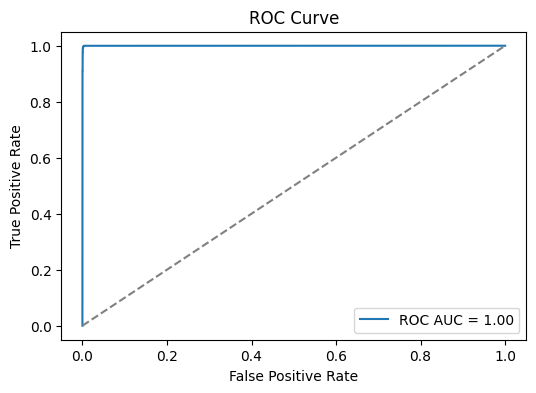

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns

y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

In [9]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4654   15]
 [   1 4310]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4669
           1       1.00      1.00      1.00      4311

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

